In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt

In [2]:
mypaths=[]
for name in glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/*',recursive=True):
    mypaths.append(name)
print(mypaths[:5])

['../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10304', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/12868', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10274', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/12818']


In [3]:
len(mypaths)

279

In [4]:
mp=mypaths[60:90]
imagePatches=[]
for i in mp:
    imagePatches+=glob(i+'/*/*.png', recursive=True)

In [5]:
print('total no. of images selected from total images is '+str(len(imagePatches)))
imagePatches[:5]

total no. of images selected from total images is 27509


['../input/breast-histopathology-images/IDC_regular_ps50_idx5/9320/0/9320_idx5_x3201_y2251_class0.png',
 '../input/breast-histopathology-images/IDC_regular_ps50_idx5/9320/0/9320_idx5_x2051_y1601_class0.png',
 '../input/breast-histopathology-images/IDC_regular_ps50_idx5/9320/0/9320_idx5_x2851_y2801_class0.png',
 '../input/breast-histopathology-images/IDC_regular_ps50_idx5/9320/0/9320_idx5_x1501_y801_class0.png',
 '../input/breast-histopathology-images/IDC_regular_ps50_idx5/9320/0/9320_idx5_x2151_y1651_class0.png']

In [6]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [7]:
print('Among them, '+str(len(class0))+' is clss0 and '+str(len(class1))+' is class1')

Among them, 19163 is clss0 and 8346 is class1


**Now Shuffling the images randomly**

In [8]:
sampled_class0 = random.sample(class0, len(class1))
sampled_class1 = random.sample(class1, len(class1))
len(sampled_class0)
class0=None;
class1=None;

In [9]:
import gc

**Now Reading all images into arrays**

In [10]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
      if i.endswith('.png'):
        img = cv2.imread(i ,cv2.IMREAD_COLOR)
        img_sized = cv2.resize(img, (227, 227), interpolation=cv2.INTER_LINEAR)
        img_arrays.append([img_sized, label])
    return img_arrays

In [11]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)
print('done')

done


In [12]:
gc.collect()

20

In [13]:
print(len(class0_array))
print(len(class1_array))

8346
8346


In [14]:
class0_array[0][0].shape

(227, 227, 3)

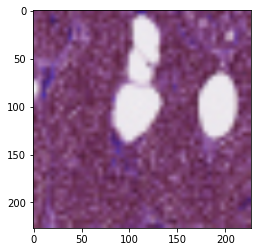

In [15]:
plt.imshow(class1_array[1][0])

In [16]:
combined_data = np.concatenate((class0_array, class1_array))
#random.seed(41)
#random.shuffle(combined_data)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [17]:
combined_data[0][0].shape

(227, 227, 3)

In [18]:
len(combined_data)

16692

**Now splitting the features and labels from the combined data**

In [19]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)


In [20]:
print(len(X))
print(len(y))

16692
16692


In [21]:
X = np.array(X).reshape(-1, 227, 227, 3)

In [22]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12519, 227, 227, 3) (4173, 227, 227, 3) (12519, 2) (4173, 2)


In [23]:
class0_array=None
class1_array=None
combined_data=None
y=None
X=None
gc.collect()

20

In [24]:
#X_train=X_train/255
#X_test=X_test/255

In [25]:
import tensorflow as tf
from tensorflow import keras

In [26]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(9216,input_shape=(12544,), activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [28]:
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)

In [29]:
X_train.shape

(12519, 227, 227, 3)

In [30]:
history=model.fit(X_train,y_train, validation_data=(X_test, y_test),epochs=10)

Epoch 1/10
392/392 [==============================] - 31s 63ms/step - loss: 0.8059 - accuracy: 0.6445 - recall: 0.6045 - val_loss: 0.4524 - val_accuracy: 0.8049 - val_recall: 0.8406
Epoch 2/10
392/392 [==============================] - 24s 61ms/step - loss: 0.5604 - accuracy: 0.7882 - recall: 0.7736 - val_loss: 0.4172 - val_accuracy: 0.8215 - val_recall: 0.8495
Epoch 3/10
392/392 [==============================] - 24s 62ms/step - loss: 0.5195 - accuracy: 0.7976 - recall: 0.7794 - val_loss: 0.4151 - val_accuracy: 0.8251 - val_recall: 0.8500
Epoch 4/10
392/392 [==============================] - 24s 61ms/step - loss: 0.4761 - accuracy: 0.8177 - recall: 0.8049 - val_loss: 0.3906 - val_accuracy: 0.8294 - val_recall: 0.8502
Epoch 5/10
392/392 [==============================] - 24s 61ms/step - loss: 0.4516 - accuracy: 0.8212 - recall: 0.8081 - val_loss: 0.3917 - val_accuracy: 0.8313 - val_recall: 0.8505
Epoch 6/10
392/392 [==============================] - 24s 61ms/step - loss: 0.4422 - accur

In [31]:
e=model.evaluate(X_test,y_test)

131/131 [==============================] - 2s 14ms/step - loss: 0.3650 - accuracy: 0.8497 - recall: 0.8591


In [32]:
import matplotlib.pyplot as plt

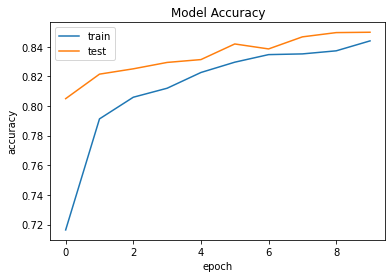

In [33]:
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

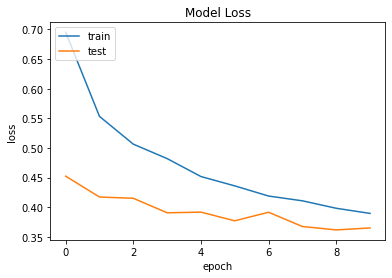

In [34]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
model.save('alexnet.h5')

In [36]:
y_pred=model.predict(X_test)

In [37]:
y_pred[21]

array([0.8937264 , 0.16500941], dtype=float32)

In [38]:
y_test[21]

array([1., 0.], dtype=float32)

0 means 1,0
1 means 0,1

In [39]:
Y_pred=[]
for i in y_pred:
    if i[0]>i[1]:
        Y_pred.append(0)
    else:
        Y_pred.append(1)

In [40]:
Y_test=[]
for i in y_test:
    if i[0]>i[1]:
        Y_test.append(0)
    else:
        Y_test.append(1)

In [41]:
Y_pred[0]

1

In [42]:
Y_test[0]

1

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test, Y_pred))
print('Classification Report')
print(classification_report(Y_test, Y_pred, target_names=['Class-0','Class-1']))

Confusion Matrix
[[1741  378]
 [ 249 1805]]
Classification Report
              precision    recall  f1-score   support

     Class-0       0.87      0.82      0.85      2119
     Class-1       0.83      0.88      0.85      2054

    accuracy                           0.85      4173
   macro avg       0.85      0.85      0.85      4173
weighted avg       0.85      0.85      0.85      4173



In [44]:
classes=[0,1]
con_mat_df = pd.DataFrame(confusion_matrix(Y_test, Y_pred),
                     index = classes, 
                     columns = classes)

In [45]:
con_mat_df

,0,1
0,1741,378
1,249,1805


In [46]:
import seaborn as sns

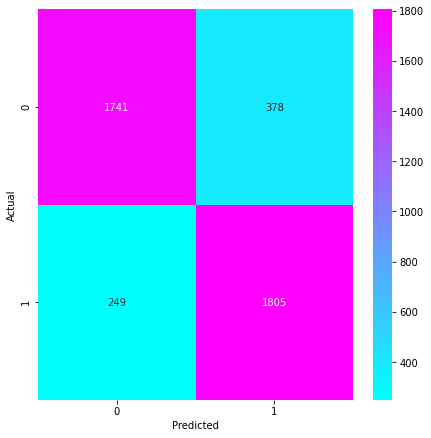

In [47]:
figure = plt.figure(figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()